## Convert pdf to jpg

In [1]:
from PIL import Image
import os
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import Image
from sklearn.cluster import KMeans
import pandas as pd
from scipy.ndimage import interpolation as inter
import tqdm
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms

C:\Users\merse\anaconda3\envs\ocr\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Convert pdf to jpg

In [2]:
path = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\new"
pages = convert_from_path(f"{path}/1.pdf")

for index,page in enumerate(pages):
    #print(index)
    page.save(f"{path}/{index}.jpg", 'JPEG')

PDFPageCountError: Unable to get page count.
I/O Error: Couldn't open file 'C:\Users\merse\Desktop\Tablature OCR\scannedTests\new/1.pdf': No such file or directory.


# Detect the subparts' coordinates

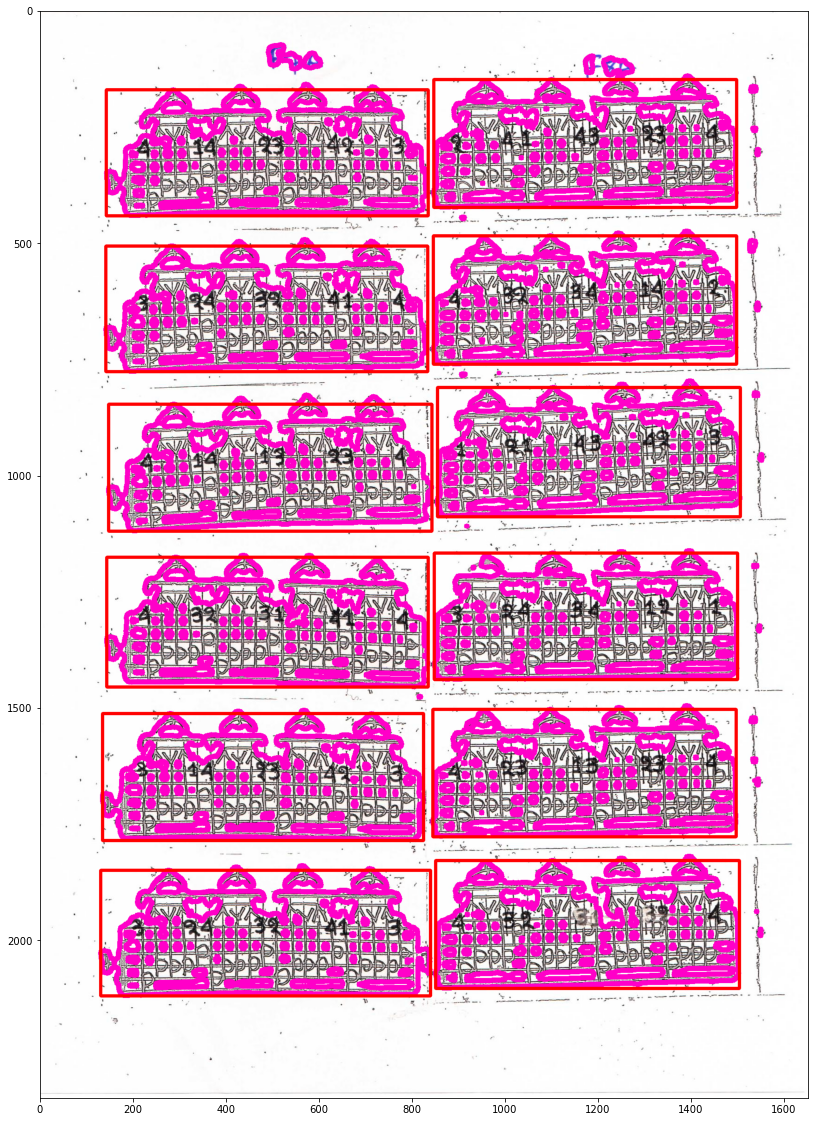

In [25]:
path_to_img = r"C:\Users\merse\Desktop\Tablature OCR\code\books_to_analyze\book1\chapter01\unit01\05.jpg"

image = cv2.imread(path_to_img)
new_image = image.copy()
#fast_denoise = cv2.fastNlMeansDenoisingColored(new_image,None,80,100,50,21)
#gray = cv2.cvtColor(fast_denoise, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 80, 255, cv2.THRESH_OTSU)

threshold = ~binary
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
with_contours = cv2.drawContours(new_image, contours, -1,(255,0,200),10)


tablature_coords = []
# Draw a bounding box around all contours
for index, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    
    # Make sure contour area is large enough
    if (cv2.contourArea(c)) > 30000:
        cv2.rectangle(with_contours,(x,y), (x+w,y+h), (255,0,0), 5)
        tablature_coords.append({"x":x, "y":y, "w":w, "h":h})
        #print(x,y,w,h)


fig = plt.figure(figsize=(20, 20))


plt.imshow(with_contours)


### if the tablature_coords len(tablature_coords) is less than 5?, then ask:


In [8]:
page = input("Enter chapter or unit (c/u):")
page

Enter chapter or unit (c/u):c


'c'

In [7]:
tablature_coords

[{'x': 108, 'y': 1861, 'w': 681, 'h': 321},
 {'x': 850, 'y': 1858, 'w': 696, 'h': 315},
 {'x': 852, 'y': 1529, 'w': 696, 'h': 300},
 {'x': 96, 'y': 1506, 'w': 679, 'h': 341},
 {'x': 73, 'y': 1166, 'w': 679, 'h': 336},
 {'x': 829, 'y': 1162, 'w': 698, 'h': 322},
 {'x': 834, 'y': 836, 'w': 696, 'h': 306},
 {'x': 58, 'y': 800, 'w': 680, 'h': 326},
 {'x': 835, 'y': 476, 'w': 697, 'h': 323},
 {'x': 56, 'y': 455, 'w': 680, 'h': 330},
 {'x': 811, 'y': 132, 'w': 700, 'h': 320},
 {'x': 44, 'y': 115, 'w': 680, 'h': 325}]

#### sort them based on sequence, left to right, top to bottom

In [159]:
sorted_tablature_coords = sorted(tablature_coords, key=lambda d: d['y'])
sorted_tablature_coords

[{'x': 265, 'y': 217, 'w': 949, 'h': 464},
 {'x': 1282, 'y': 296, 'w': 956, 'h': 452},
 {'x': 260, 'y': 734, 'w': 949, 'h': 459},
 {'x': 1275, 'y': 785, 'w': 957, 'h': 449},
 {'x': 268, 'y': 1251, 'w': 951, 'h': 453},
 {'x': 1288, 'y': 1275, 'w': 957, 'h': 448},
 {'x': 260, 'y': 1821, 'w': 955, 'h': 453},
 {'x': 1277, 'y': 1832, 'w': 956, 'h': 453},
 {'x': 1271, 'y': 2310, 'w': 959, 'h': 462},
 {'x': 262, 'y': 2337, 'w': 954, 'h': 449},
 {'x': 1288, 'y': 2797, 'w': 958, 'h': 473},
 {'x': 277, 'y': 2853, 'w': 958, 'h': 447}]

In [160]:
for i in range(0, len(sorted_tablature_coords), 2):
    if sorted_tablature_coords[i]['x']>sorted_tablature_coords[i+1]['x']:
        sorted_tablature_coords[i], sorted_tablature_coords[i+1]  = sorted_tablature_coords[i+1], sorted_tablature_coords[i]

In [161]:
sorted_tablature_coords

[{'x': 265, 'y': 217, 'w': 949, 'h': 464},
 {'x': 1282, 'y': 296, 'w': 956, 'h': 452},
 {'x': 260, 'y': 734, 'w': 949, 'h': 459},
 {'x': 1275, 'y': 785, 'w': 957, 'h': 449},
 {'x': 268, 'y': 1251, 'w': 951, 'h': 453},
 {'x': 1288, 'y': 1275, 'w': 957, 'h': 448},
 {'x': 260, 'y': 1821, 'w': 955, 'h': 453},
 {'x': 1277, 'y': 1832, 'w': 956, 'h': 453},
 {'x': 262, 'y': 2337, 'w': 954, 'h': 449},
 {'x': 1271, 'y': 2310, 'w': 959, 'h': 462},
 {'x': 277, 'y': 2853, 'w': 958, 'h': 447},
 {'x': 1288, 'y': 2797, 'w': 958, 'h': 473}]

## Plot the segmented images

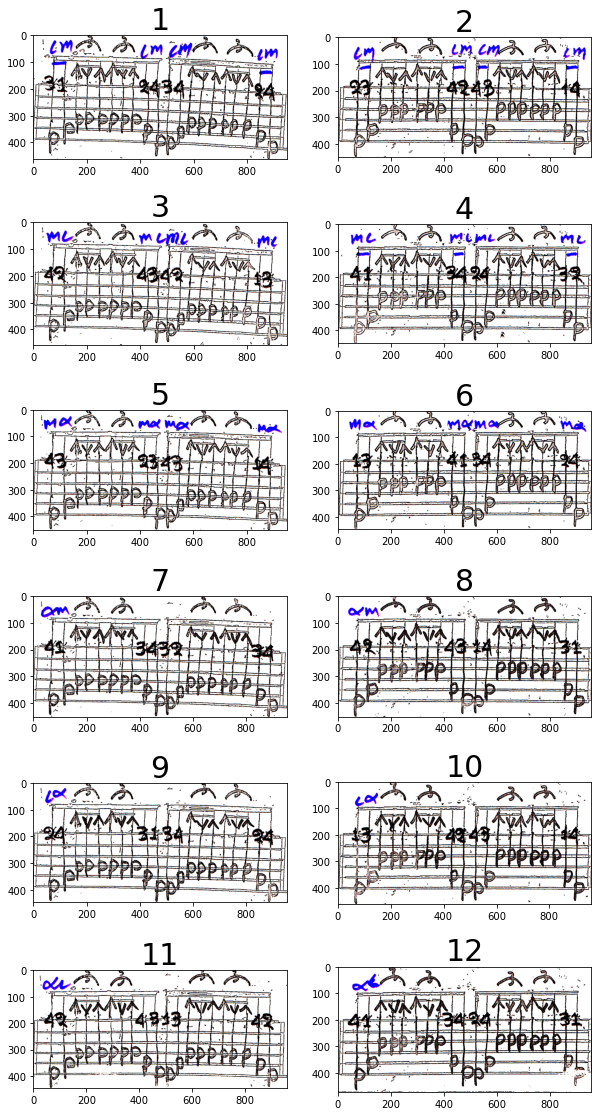

In [162]:
image = cv2.imread(path_to_img)

# ADD CONTRAST
contrast = 5 # Contrast control (1.0-3.0)
brightness = -600 # Brightness control (0-100)
image = cv2.addWeighted( image, contrast, image, 0, brightness)


margin = 0

fig = plt.figure(figsize=(10, 20))
tab = []
for index, i in enumerate(sorted_tablature_coords):
    tab.append(image[i["y"] - margin : i["y"] + i["h"] + margin, i["x"] - margin : i["x"] + i["w"] + margin])
    number_of_rows = int(len(sorted_tablature_coords)/2)
    fig.add_subplot(number_of_rows, 2, index+1)
    plt.gca().set_title(index+1, fontsize=30)
    plt.imshow(tab[index])
    

plt.show()

### save the segmented images IN GRAY

In [163]:

image = cv2.imread(path_to_img)

# ADD CONTRAST
contrast = 5 # Contrast control (1.0-3.0)
brightness = -600 # Brightness control (0-100)
image = cv2.addWeighted( image, contrast, image, 0, brightness)



margin = 0

subPartsPath = os.path.join(r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\new", "parts8")
if not os.path.exists(subPartsPath):
    os.makedirs(subPartsPath)


for index, i in enumerate(sorted_tablature_coords):
    cropped_img = image[i["y"] - margin : i["y"] + i["h"] + margin, i["x"] - margin : i["x"] + i["w"] + margin]
    gray_cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

    cv2.imwrite(f"{subPartsPath}/8.{1 + index}.jpg", gray_cropped_img)


## SKEW CORRECTION

In [4]:
def correct_skew(image, delta=0.2, limit=10):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
          borderMode=cv2.BORDER_REPLICATE)

    return best_angle, rotated



if __name__ == '__main__':
    
    directory = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\test_images\trixordo"

    for filename in os.listdir(directory):
        
        path_to_img = os.path.join(directory, filename)
    
        image = cv2.imread(path_to_img)
        angle, rotated = correct_skew(image)
        print(angle)

        # PROSOXH KANO SAVE TO ROTATED IMAGE
        cv2.imwrite(f"{directory}/rotated{filename}", rotated)
        #cv2.imshow('rotated', rotated)
        #cv2.imwrite('rotated.png', rotated)
        #cv2.waitKey()





C:\Users\merse\AppData\Local\Temp\ipykernel_16416\1224831258.py:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


-0.20000000000003482
-1.2000000000000313
1.5999999999999588
-0.20000000000003482
1.5999999999999588
-0.20000000000003482
-2.2000000000000277
-0.6000000000000334
-1.8000000000000291
-1.4000000000000306
-3.200000000000024
0.39999999999996305
-1.4000000000000306
0.9999999999999609


## Line detection

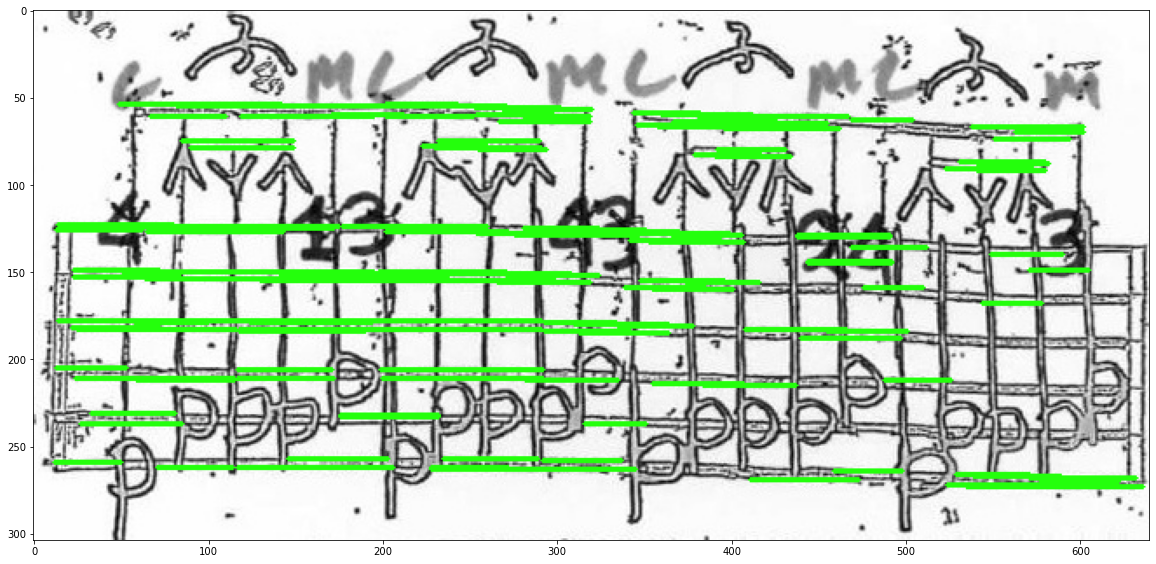

In [59]:

path_to_img = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\test_images\8rotated1.jpg"
#path_to_img = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\trixordo\1.jpg"


# Load image, convert to grayscale, Otsu's threshold
image = cv2.imread(path_to_img)
imgCp = image.copy()
gray = cv2.cvtColor(imgCp,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

"""
# Detect vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
verticalContours = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
verticalContours = verticalContours[0] if len(verticalContours) == 2 else verticalContours[1]
for vc in verticalContours:
    cv2.drawContours(imgCp, [vc], -1, (36,255,12), 2)
    #plt.imshow(cv2.drawContours(imgCp, [vc], -1, (36,255,12), 2))
"""

# Detect horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
horizontalContours = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
horizontalContours = horizontalContours[0] if len(horizontalContours) == 2 else horizontalContours[1]
for hc in horizontalContours:
    cv2.drawContours(imgCp, [hc], -1, (36,255,12), 2)
    #print(hc)
    #print("------------")


plt.figure(figsize=(20, 20))
plt.imshow(imgCp)


# ADD AN OPTION TO DELETE TOP AND BOTTOM NOISE LINES

In [60]:
len(horizontalContours)

68

In [61]:
pd.set_option('display.max_rows', None)
df = pd.DataFrame(np.vstack(np.concatenate(horizontalContours)), columns=['x', 'y'])
sorted_df = df.sort_values('y',ignore_index=True)
sorted_df[["y"]]

,y
0,54
1,54
2,54
3,54
4,54
5,54
6,54
7,55
8,55
9,55


### K-means

In [62]:
X = sorted_df[["y"]]
kmeans = KMeans(n_clusters=8, random_state = 0).fit(X)
#kmeans.labels_
centroids = np.copy(kmeans.cluster_centers_)
sorted_centroids = np.sort(centroids, axis = 0)
sorted_centroids

C:\Users\merse\anaconda3\envs\ocr\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


array([[ 60.73972603],
       [ 82.39473684],
       [128.01666667],
       [153.        ],
       [181.19148936],
       [210.85185185],
       [234.        ],
       [264.97435897]])

In [14]:
def which_cluster(centroids, value):
    distance = np.abs(centroids - value)
    return np.argmin(distance)

v = 200
which_cluster(sorted_centroids, v)

5

### Extract one string

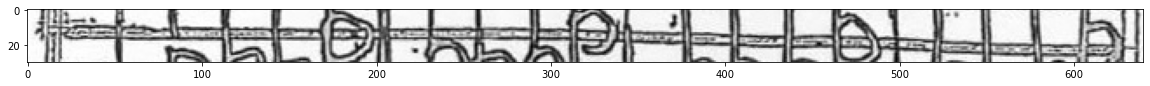

In [77]:
string_number = 5

y_margin = 15
extra_margin = 0

image = cv2.imread(path_to_img)
new_image = image.copy()
lower_limit = int(sorted_centroids[string_number]) + y_margin 
upper_limit = int(sorted_centroids[string_number]) - y_margin + extra_margin
cropped_image = new_image[upper_limit:lower_limit, :]
plt.figure(figsize=(20, 20))
plt.imshow(cropped_image)

## model testing

In [28]:
model_path = r"C:\Users\merse\Desktop\Tablature OCR\model\model2.pth"

model = core.Model.load(model_path, ["p", "i", "m", "a", "1", "2", "3", "4"])

<Figure size 1440x1440 with 0 Axes>

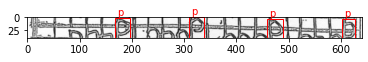

In [57]:
thresh = 0.28

#test = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\test_images\12rotated2.jpg"
test = cropped_image.copy()


predictions = model.predict(test)
labels, boxes, scores = predictions

filtered_indices = np.where(scores > thresh)
filtered_scores = scores[filtered_indices]
filtered_boxes = boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(test, filtered_boxes, filtered_labels)

### Erase lines

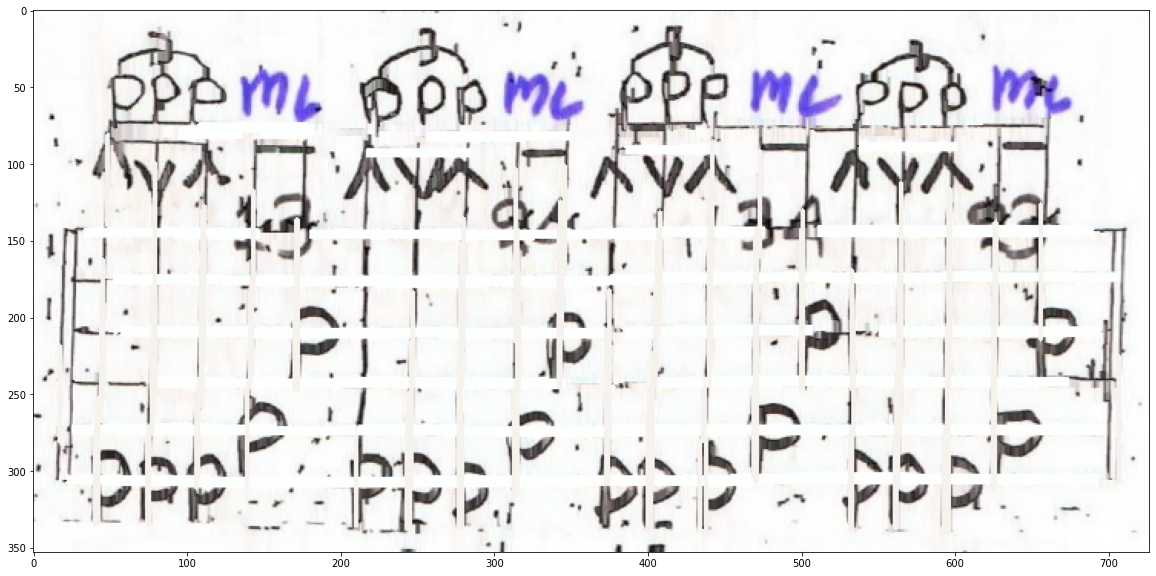

In [90]:
import cv2
path_to_img = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\subparts2\rotated4.jpg"

image = cv2.imread(path_to_img)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30,1))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (253,254,254), 2)
    
    
    
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,30))
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
verticalContours = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
verticalContours = verticalContours[0] if len(verticalContours) == 2 else verticalContours[1]
for vc in verticalContours:
    cv2.drawContours(image, [vc], -1, (246,243,238), 2)
    

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

#grayres = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
#threshres = cv2.threshold(grayres, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

plt.figure(figsize=(20, 20))
plt.imshow(result)
